# Minimierung der Lateness jedes Produktionsauftrags

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**
- $L_j = 0$: Job ist **pünktlich**
- $L_j < 0$: Job ist **zu früh** fertig

$\min \; Z =
\underbrace{
w_{\text{main}} \cdot \left(
w_t \cdot \sum_{j \in \mathcal{J}} T_j
+ w_e \cdot \sum_{j \in \mathcal{J}} E_j
+ w_{\text{first}} \cdot \sum_{j \in \mathcal{J}} F_j
\right)
}_{\text{Lateness-Komponente}}
\; + \;
\underbrace{
(1 - w_{\text{main}}) \cdot \sum_{(j,o) \in \mathcal{P}} D_{jo}
}_{\text{Abweichungskomponente}}$

$\mathcal{J}$ … Menge aller Jobs
$\mathcal{P}$ … Menge aller Operationen mit vorherigem Planbezug

$T_j = \max(0, \text{Ende}_j - \text{Deadline}_j)$ … Tardiness (Verspätung)
$E_j = \max(0, \text{Deadline}_j - \text{Ende}_j)$ … Earliness (zu früh)
$F_j = \max(0, \text{Wunschstart}_j - \text{Start}_{j,0})$ … Frühstartstrafe der ersten Operation

$D_{jo} =
\begin{cases}
|S_{jo}^{\text{neu}} - S_{jo}^{\text{alt}}| & \text{(Startzeitabweichung)} \\
\text{Anzahl der Inversionen (Kendall-Tau)} & \text{(Reihenfolgeabweichung)}
\end{cases}$


In [26]:
import json
import pandas as pd
from decimal import Decimal

# Utils
import src.utils.visualization.gantt_diagram as gantt

# Analysis utils
from src.utils.analysis_basics import check_constraints as check
from src.utils.analysis_basics.check_lateness import get_jobs_with_lateness_metrics, get_jobs_aggregated
from src.utils.analysis.compare_sequences import get_comparison_dataframe, compute_sum_levenshtein_distance, \
    compute_mean_kendall_tau, get_shared_operations_number

# Solver
from src.solvers.CP_Solver import Solver

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Data access
from configs.path_manager import get_path

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [4]:
# Database and Collections
from src.domain.Query import JobQuery
from src.domain.Collection import LiveJobCollection

In [27]:
# Hard termination condition for schedulers
max_time = 60*5     # 5 min

# File paths
examples_data_path = get_path("data", "examples")
logs_path = get_path("data", "logs")

# Simulation
simulation = ProductionSimulation(sigma = 0.2)

In [17]:
jobs = JobQuery.get_by_max_bottleneck_utilization(Decimal("0.85"))
jobs_collection = LiveJobCollection(jobs)
jobs_collection.to_jobs_dataframe()

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,01-08500-0000,01-07,0,1440,None
1,01-08500-0016,01-07,1504,2880,None
2,01-08500-0029,01-07,2352,2880,None
3,01-08500-0034,01-07,2791,2880,None
4,01-08500-0047,01-07,3513,4320,None
5,01-08500-0053,01-07,3949,4320,None
...,...,...,...,...,...
9598,01-08500-9541,01-08,715701,717120,None
9599,01-08500-9557,01-08,717245,718560,None
9600,01-08500-9566,01-08,718254,718560,None


## Day 1
- On day 0, the first jobs (production orders) arrive, so nothing can be planned yet
- On day 1, the initial planning takes place

In [18]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [22]:
# New jobs that must be scheduled
current_jobs_collection = jobs_collection.get_subset_by_earliest_start(earliest_start=day_start)


In [23]:
df_jssp_current = current_jobs_collection.to_operations_dataframe()
df_jssp_current

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,01-08500-0000,01-07,0,M01-02,None,31,None,1440,None
1,01-08500-0000,01-07,1,M01-00,None,86,None,1440,None
2,01-08500-0000,01-07,2,M01-01,None,46,None,1440,None
3,01-08500-0000,01-07,3,M01-05,None,74,None,1440,None
4,01-08500-0000,01-07,4,M01-04,None,32,None,1440,None
5,01-08500-0000,01-07,5,M01-06,None,88,None,1440,None
...,...,...,...,...,...,...,...,...,...
154,01-08500-0012,01-08,4,M01-02,None,85,None,1440,None
155,01-08500-0012,01-08,5,M01-09,None,11,None,1440,None
156,01-08500-0012,01-08,6,M01-06,None,40,None,1440,None


In [24]:
df_jobs_times_current = current_jobs_collection.to_jobs_dataframe()
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,01-08500-0000,01-07,0,1440,None
1,01-08500-0001,01-06,53,1440,None
2,01-08500-0010,01-06,1002,1440,None
3,01-08500-0002,01-01,125,1440,None
4,01-08500-0015,01-01,1437,1440,None
5,01-08500-0003,01-05,174,1440,None
6,01-08500-0004,01-04,219,1440,None
7,01-08500-0013,01-04,1178,1440,None
8,01-08500-0005,01-02,443,1440,None
9,01-08500-0011,01-02,1007,1440,None


### Scheduling

In [ ]:
solver = Solver(
    jobs_collection = current_jobs_collection,
    schedule_start= day_start
)
solver.build_model_for_jssp_lateness_with_start_deviation_minimization(
    previous_schedule_jobs_collection=None,
    active_jobs_collection=None,
    w_t = 5, w_e = 1, w_first = 1,
    duration_buffer_factor= 2
)
model_log = solver.get_model_info()
print(json.dumps(model_log, indent=2))

In [ ]:
log_file_path = logs_path / "cp_lateness_with_w_first_init.log"

solver.solve_model(
    log_file= log_file_path,
    gap_limit= 0.02,
    time_limit= max_time
)
solver_info = solver.get_solver_info()
print(json.dumps(solver_info, indent=2))

In [ ]:
schedule_jobs_collection = solver.get_schedule()
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_01.csv", index=False)
df_schedule

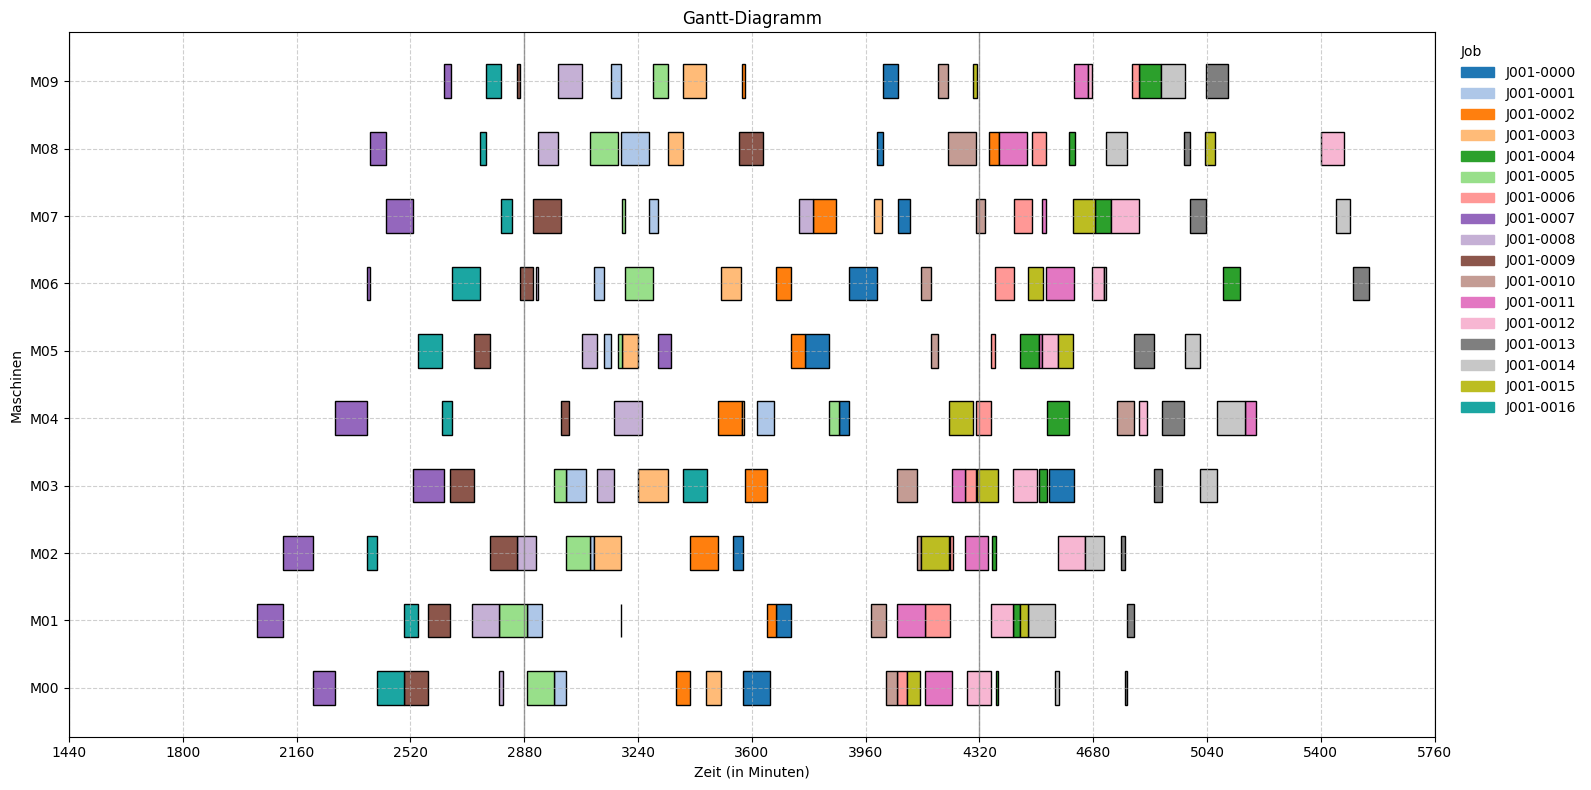

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.
+ All durations match the difference between start and end.


True

In [15]:
gantt.get_plot(df_schedule, perspective="Machine")
#df_schedule_with_info = enrich_schedule_dframe(df_schedule, df_jobs_times)
check.check_core_schedule_constraints(df_schedule)
check.is_start_correct(df_schedule, df_jobs_times_current)
check.is_duration_correct(df_schedule)


In [ ]:
-

In [16]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

Tardiness_Interval,0,0 - 60,60 - 120,>120
count,17,0,0,0


### Simulation

In [17]:
simulation.run(schedule_collection = schedule_jobs_collection, start_time = day_start, end_time=day_end)

[Day 1 09:56:00] Job J001-0007 started on M01
[Day 1 11:08:00] Job J001-0007 finished on M01 (after 72 minutes)
[Day 1 11:17:00] Job J001-0007 started on M02
[Day 1 13:02:00] Job J001-0007 finished on M02 (after 105 minutes)
[Day 1 13:02:00] Job J001-0007 started on M00
[Day 1 14:12:00] Job J001-0007 finished on M00 (after 70 minutes)
[Day 1 14:12:00] Job J001-0007 started on M04
[Day 1 15:35:00] Job J001-0007 finished on M04 (after 83 minutes)
[Day 1 15:42:00] Job J001-0016 started on M02
[Day 1 15:42:00] Job J001-0007 started on M06
[Day 1 15:51:00] Job J001-0007 finished on M06 (after 09 minutes)
[Day 1 15:51:00] Job J001-0007 started on M08
[Day 1 16:16:00] Job J001-0016 finished on M02 (after 34 minutes)
[Day 1 16:16:00] Job J001-0016 started on M00
[Day 1 16:36:00] Job J001-0007 finished on M08 (after 45 minutes)
[Day 1 16:43:00] Job J001-0007 started on M07
[Day 1 17:55:00] Job J001-0016 finished on M00 (after 99 minutes)
[Day 1 17:55:00] Job J001-0009 started on M00
[Day 1 17:5

In [18]:
finished_job_ops_collection = simulation.get_finished_operation_collection()
df_execution = finished_job_ops_collection.to_dataframe()
df_execution

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,J001-0007,3,0,M01,2036.0,72.0,2108.0,1440,3346
1,J001-0007,3,1,M02,2117.0,105.0,2222.0,1440,3346
2,J001-0007,3,2,M00,2222.0,70.0,2292.0,1440,3346
3,J001-0007,3,3,M04,2292.0,83.0,2375.0,1440,3346
4,J001-0007,3,4,M06,2382.0,9.0,2391.0,1440,3346
5,J001-0007,3,5,M08,2391.0,45.0,2436.0,1440,3346
...,...,...,...,...,...,...,...,...,...
20,J001-0009,8,2,M03,2644.0,67.0,2711.0,1440,3635
21,J001-0009,8,3,M05,2720.0,45.0,2765.0,1440,3635
22,J001-0009,8,4,M02,2771.0,84.0,2855.0,1440,3635


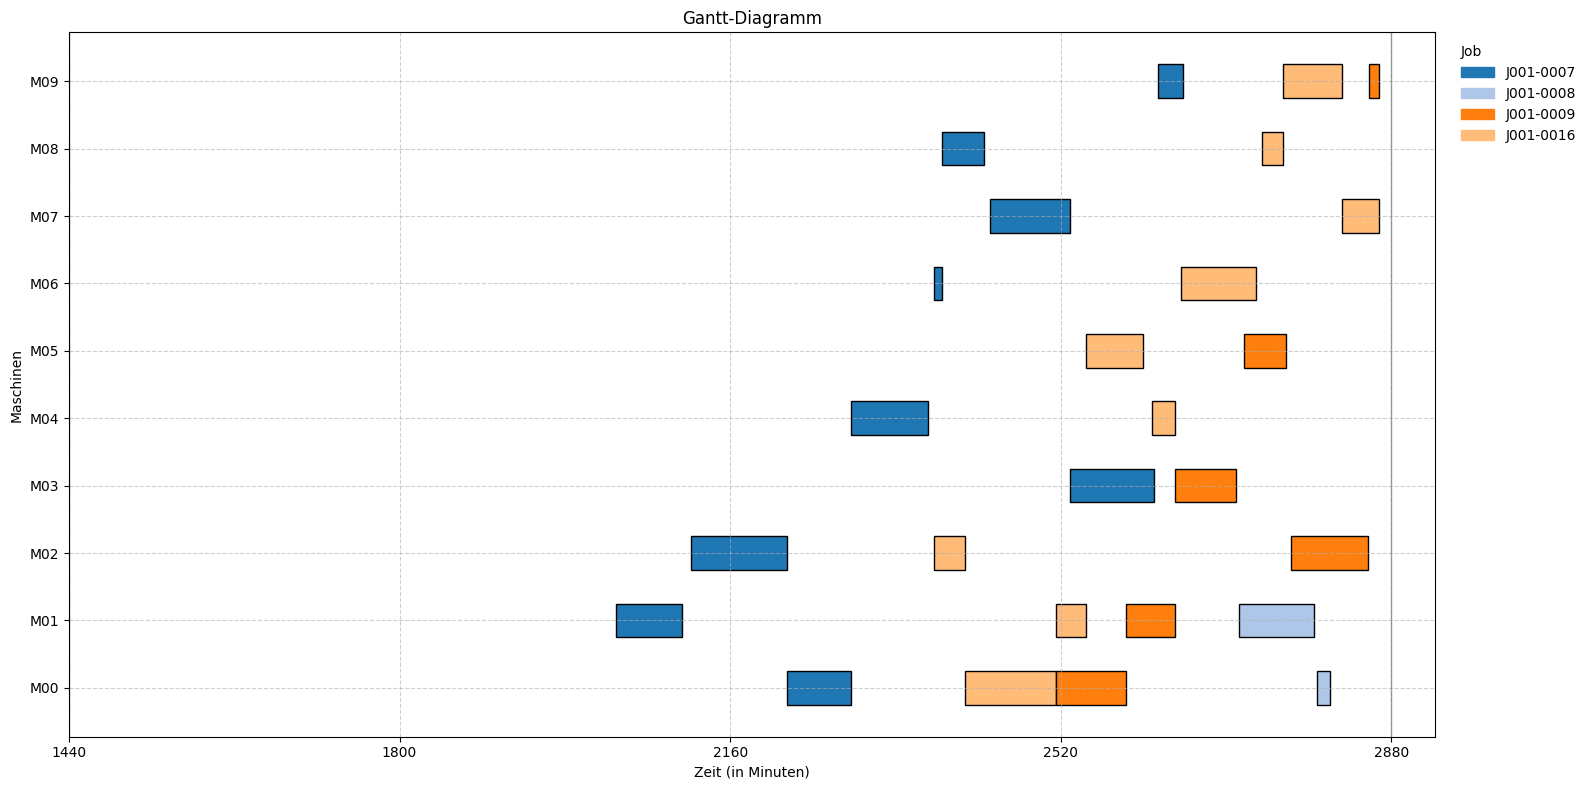

In [19]:
gantt.get_plot(df_execution, perspective="Machine")

In [20]:
active_job_ops_collection = simulation.get_active_operation_collection()
df_active = active_job_ops_collection.to_dataframe()
df_active

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,J001-0005,2,0,M01,2799.0,89.0,2888.0,1440,3877
1,J001-0008,9,2,M02,2856.0,57.0,2913.0,1440,3794
2,J001-0009,8,6,M06,2867.0,34.0,2901.0,1440,3635


In [21]:
waiting_job_ops_collection = simulation.get_waiting_operation_collection()
waiting_job_ops_collection.to_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,J001-0000,7,0,M02,3542,31,3573,1440,4620
1,J001-0000,7,1,M00,3573,86,3659,1440,4620
2,J001-0000,7,2,M01,3677,46,3723,1440,4620
3,J001-0000,7,3,M05,3769,74,3843,1440,4620
4,J001-0000,7,4,M04,3877,32,3909,1440,4620
5,J001-0000,7,5,M06,3909,88,3997,1440,4620
...,...,...,...,...,...,...,...,...,...
135,J001-0015,1,5,M01,4447,28,4475,1440,5064
136,J001-0015,1,6,M06,4475,46,4521,1440,5064
137,J001-0015,1,7,M05,4569,46,4615,1440,5064


## Day 2
- This is where the new scheduling takes place, i.e., scheduling with specific consideration of the simulation.

In [22]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [23]:
# New and previous jobs that must be scheduled
current_job_times_collection_temp = job_collection.get_subset_by_earliest_start(earliest_start=day_start)
current_job_times_collection = current_job_times_collection_temp + waiting_job_ops_collection

In [24]:
# Test
current_job_times_collection_temp.to_information_dataframe()

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,J001-0017,5,1606,2880,6037
1,J001-0018,3,1656,2880,7290
2,J001-0019,0,1661,2880,5767
3,J001-0020,5,1670,2880,6124
4,J001-0021,3,1685,2880,6902
5,J001-0022,1,1729,2880,4811
...,...,...,...,...,...
23,J001-0040,3,2759,2880,6263
24,J001-0041,2,2785,2880,5956
25,J001-0042,1,2804,2880,6377


In [25]:
# Test
current_job_times_collection_temp.to_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,J001-0017,5,0,M02,None,84,None,2880,6037
1,J001-0017,5,1,M01,None,2,None,2880,6037
2,J001-0017,5,2,M05,None,52,None,2880,6037
3,J001-0017,5,3,M03,None,95,None,2880,6037
4,J001-0017,5,4,M08,None,48,None,2880,6037
5,J001-0017,5,5,M09,None,72,None,2880,6037
...,...,...,...,...,...,...,...,...,...
284,J001-0045,5,4,M08,None,48,None,2880,6799
285,J001-0045,5,5,M09,None,72,None,2880,6799
286,J001-0045,5,6,M00,None,47,None,2880,6799


In [26]:
df_jobs_times_current = current_job_times_collection.to_information_dataframe()
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,J001-0017,5,1606,2880,6037
1,J001-0018,3,1656,2880,7290
2,J001-0019,0,1661,2880,5767
3,J001-0020,5,1670,2880,6124
4,J001-0021,3,1685,2880,6902
5,J001-0022,1,1729,2880,4811
...,...,...,...,...,...
40,J001-0011,2,856,1440,5194
41,J001-0012,8,921,1440,5474
42,J001-0013,4,1001,1440,5554


In [27]:
df_jssp_current = current_job_times_collection.to_dataframe()
df_jssp_current

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,J001-0017,5,0,M02,NaN,84,NaN,2880,6037
1,J001-0017,5,1,M01,NaN,2,NaN,2880,6037
2,J001-0017,5,2,M05,NaN,52,NaN,2880,6037
3,J001-0017,5,3,M03,NaN,95,NaN,2880,6037
4,J001-0017,5,4,M08,NaN,48,NaN,2880,6037
5,J001-0017,5,5,M09,NaN,72,NaN,2880,6037
...,...,...,...,...,...,...,...,...,...
425,J001-0015,1,5,M01,4447.0,28,4475.0,1440,5064
426,J001-0015,1,6,M06,4475.0,46,4521.0,1440,5064
427,J001-0015,1,7,M05,4569.0,46,4615.0,1440,5064


### Scheduling (Rescheduling)

In [28]:
previous_schedule_jobs_collection = schedule_jobs_collection
df_previous_schedule = previous_schedule_jobs_collection.to_information_dataframe()

#### a) Simple Scheduling


===== EXPERIMENT LOG SUMMARY =====
[EXPERIMENT_INFO]
  total_number_of_operations                        : 431
  number_of_operations_with_previous_schedule       : 0
  number_of_active_operation_to_consider            : 3
  schedule_start                                    : 2880
[EXPERIMENT_CONFIG]
  main_pct                                          : 1.0
  w_t                                               : 10
  w_e                                               : 2
  w_first                                           : 1
  deviation_type                                    : start
  solver_time_limit                                 : 120
  solver_relative_gap_limit                         : 0.05
[MODEL_INFO]
  number_of_variables                               : 1143
  number_of_constraints                             : 1156
  number_of_deviation_terms                         : 0
[SOLVER_INFO]
  status                                            : OPTIMAL
  objective_value             

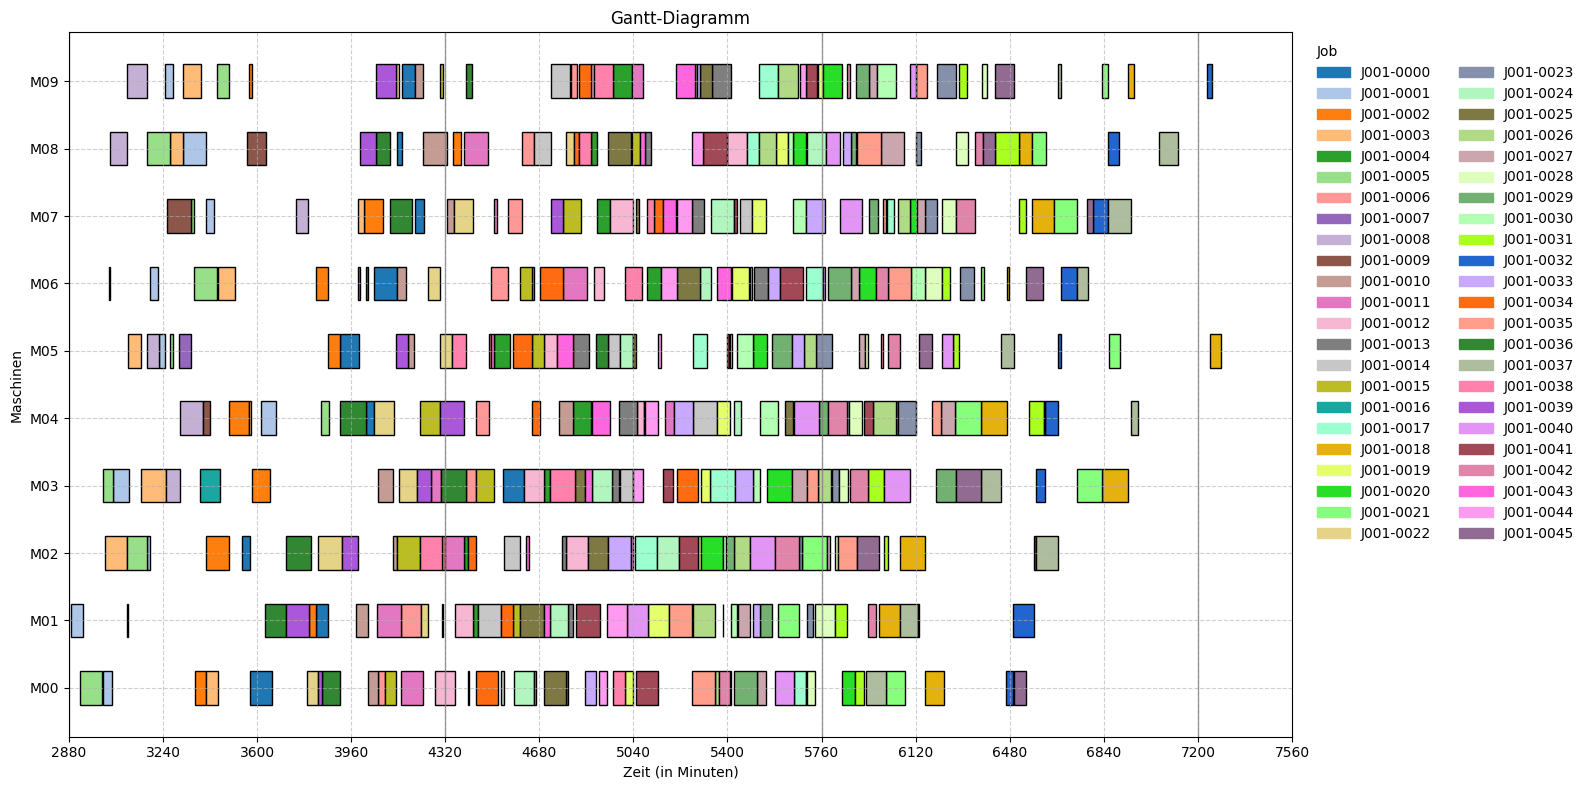

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.


True

In [29]:
schedule_jobs_collection, log = solve_jssp_lateness_with_start_deviation_minimization(
        jobs_collection=current_job_times_collection,
        previous_schedule_jobs_collection=None,
        active_jobs_collection=active_job_ops_collection,
        w_t= 10, w_e=2, w_first=1,
        main_pct=1, duration_buffer_factor = 2,
        schedule_start=day_start, msg=False,
        solver_time_limit=max_time, solver_relative_gap_limit=0.05
    )
print_experiment_log(log)
df_schedule = schedule_jobs_collection.to_dataframe()
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)

In [30]:
get_comparison_dataframe(df_previous_schedule, df_schedule, comparison_start_time=day_start)

KeyError: 'Start_prev'

In [31]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

KeyError: 'Start_prev'

In [32]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

Tardiness_Interval,0,0 - 60,60 - 120,>120
count,46,0,0,0


### b) with 'start' deviation penalty


===== EXPERIMENT LOG SUMMARY =====
[EXPERIMENT_INFO]
  total_number_of_operations                        : 431
  number_of_operations_with_previous_schedule       : 170
  number_of_active_operation_to_consider            : 3
  schedule_start                                    : 2880
[EXPERIMENT_CONFIG]
  main_pct                                          : 0.5
  w_t                                               : 10
  w_e                                               : 2
  w_first                                           : 1
  deviation_type                                    : start
  solver_time_limit                                 : 120
  solver_relative_gap_limit                         : 0.05
[MODEL_INFO]
  number_of_variables                               : 1284
  number_of_constraints                             : 1297
  number_of_deviation_terms                         : 141
[SOLVER_INFO]
  status                                            : FEASIBLE
  objective_value        

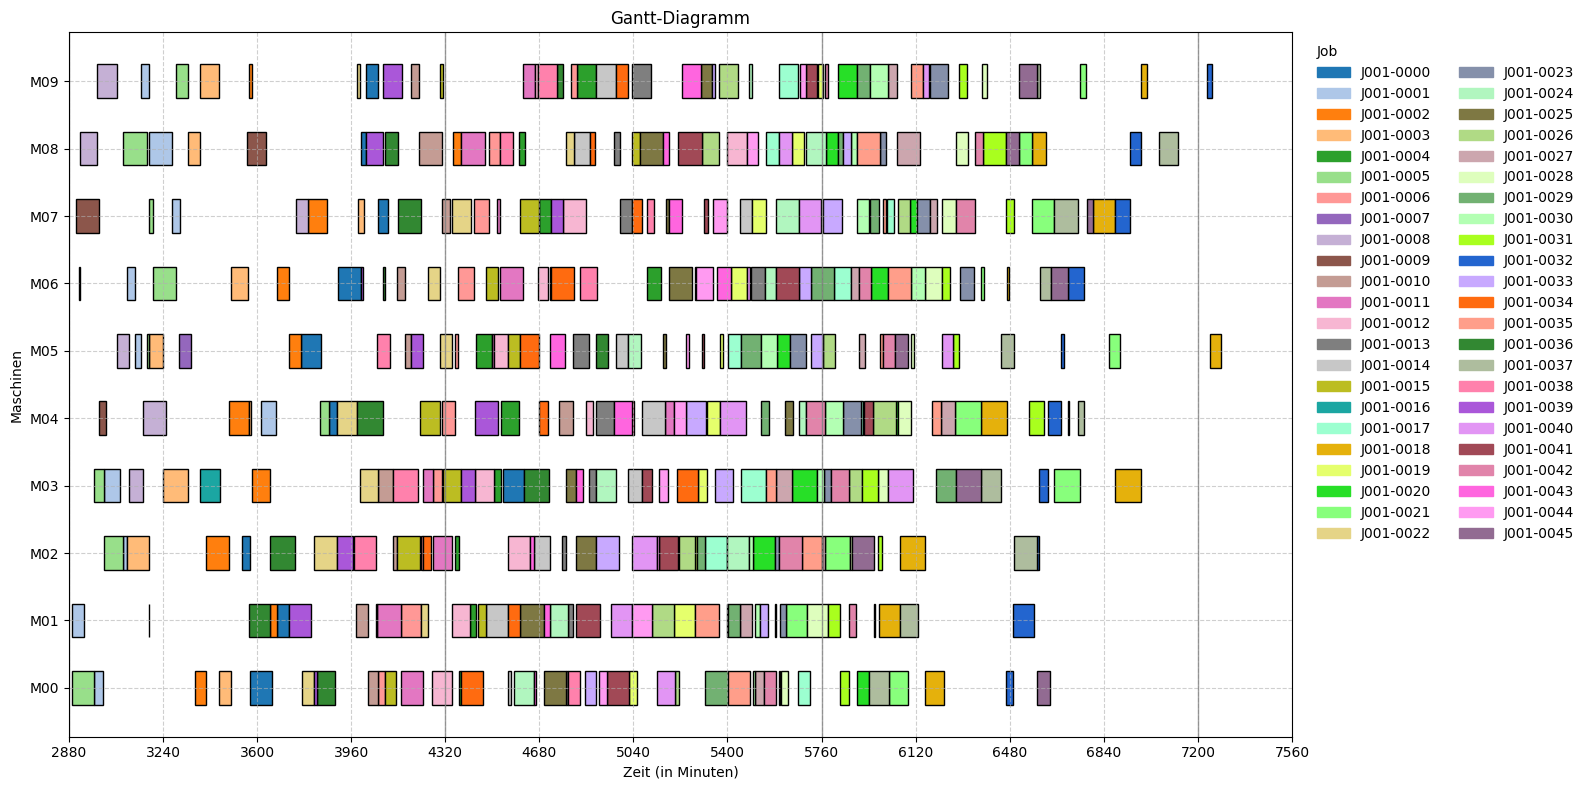

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.


True

In [33]:
schedule_jobs_collection, log = solve_jssp_lateness_with_start_deviation_minimization(
        jobs_collection=current_job_times_collection,
        previous_schedule_jobs_collection=previous_schedule_jobs_collection,
        active_jobs_collection=active_job_ops_collection,
        w_t= 10, w_e=2, w_first=1,
        main_pct=(1/2),                  # 50% Lateness+, 50% Deviation
        duration_buffer_factor = 2,
        schedule_start=day_start, msg=False,
        solver_time_limit=max_time, solver_relative_gap_limit=0.05
    )

print_experiment_log(log)
df_schedule = schedule_jobs_collection.to_dataframe()
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)

In [ ]:
get_comparison_dataframe(df_previous_schedule, df_schedule, comparison_start_time=day_start)

In [ ]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

In [34]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

Tardiness_Interval,0,0 - 60,60 - 120,>120
count,45,1,0,0


### c) with 'order on machines' deviation penalty

In [ ]:
"""
schedule_jobs_collection, log = solve_jssp_lateness_with_order_deviation_minimization(
        jobs_collection=current_job_times_collection,
        previous_schedule_jobs_collection=previous_schedule_jobs_collection,
        active_jobs_collection=active_job_ops_collection,
        w_t= 10, w_e=2, w_first=1,
        main_pct=(1/2),                  # 50% Lateness+, 50% Deviation
        duration_buffer_factor = 2,
        schedule_start=day_start, msg=False,
        solver_time_limit=max_time, solver_relative_gap_limit=0.05
    )
"""


#### Check the conditions of the combined data set from the simulation data with the new schedule

In [ ]:
df_reschedule = df_schedule

columns = ["Job", "Operation", "Machine", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.check_core_schedule_constraints(df_combined)

In [ ]:
-

### Simulation

In [ ]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time = day_end)

In [ ]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

In [ ]:
gantt.get_plot(df_execution2, perspective="Machine")

In [ ]:
df_active2 = simulation.get_active_operations_df()
df_active2

#### Check the conditions of the combined data set from the two simulation data sets

In [ ]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.check_core_schedule_constraints(df_combined)